# Project 4: Regression Analysis

In [1]:
# Requirements: pandas, scikit-learn, matplotlib, plotly

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Prevent codes being displayed when exporting to an HTML file
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) {jQuery(".input_area").toggle(); jQuery(".prompt").toggle();} jQuery(".highlight").show();});</script>', raw=True)

# Dynamically add a button to show/hide codes
di.display_html("<script>jQuery(function() {jQuery(function() {var b = jQuery('<input type=\"button\" value=\"Show/Hide codes\"/>'); b.click(function(){jQuery('.input_area').each(function(){jQuery(this).toggle();});}); jQuery('[id^=Project]').parent().append(b);});});</script>", raw=True)

### Load the dataset

In [2]:
# import numpy as np

# names = ['Week','Day','Hour','Work_Flow','File','Size','Time']
# data = np.genfromtxt('./network_backup_dataset.csv', delimiter=',', names=names, dtype=None, skip_header=1) 

In [3]:
import pandas as pd

df = pd.read_csv('./network_backup_dataset.csv')
df_group = df.groupby([df.columns[0], df.columns[1], df.columns[3]], sort=False).sum().iloc[:,1:2]
# df_group = df_group.reset_index()
# df_group.head()

In [4]:
sizes = [[],[],[],[],[]]
length=0
for index, row in df_group.iterrows():
    sizes[int(index[2][-1])].append(row[0])

In [5]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

def draw_lines(y, n, title=''):
    data = []
    
    for i in range(5):
        trace = go.Scatter(x=range(1,n+1), y=y[i][:n], mode='lines', 
                           line=dict(width=2), name=('work_flow_'+str(i)))
        data.append(trace)

    layout = go.Layout(title=title,
                       xaxis=dict(title='Day', dtick=7),
                       yaxis=dict(title='Backup sizes', ticks='outside'))

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [6]:
draw_lines(sizes, 20, 'Daily backup sizes for every workflows (20 days)')
draw_lines(sizes, 105, 'Daily backup sizes for every workflows (105 days)')

### Predict backup size

In [7]:
import calendar
days = dict(zip(calendar.day_name,range(1,8)))

df.drop('Backup Time (hour)', axis=1, inplace=True)
df['Day of Week'] = df['Day of Week'].apply(lambda s: days[s])

f = lambda s: int(s[s.rindex('_')+1:])

df['Work-Flow-ID'] = df['Work-Flow-ID'].apply(f)
df['File Name'] = df['File Name'].apply(f)
# df.head()

In [8]:
Xs, ys = [], []
for key, value in df.groupby('Work-Flow-ID').groups.items():
    group = df.loc[value].drop('Work-Flow-ID', axis=1).reset_index(drop=True)
    Xs.append(group.drop('Size of Backup (GB)', axis=1))
    ys.append(group[['Size of Backup (GB)']])

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

def cv_linear(model, X, y):
    kf = KFold(n_splits=10)
    rmse_train, rmse_test = 0, 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        model.fit(X_train, y_train)
        rmse_train += mean_squared_error(y_train, model.predict(X_train))
        rmse_test += mean_squared_error(y_test, model.predict(X_test))

    return sqrt(rmse_train / 10), sqrt(rmse_test / 10)

In [10]:
# Question 2d_i: 
for i in range(len(ys)):
    rmse_train, rmse_test = cv_linear(LinearRegression(), Xs[i], ys[i])
    print("%s: RMSE_train = %f RMSE_test = %f" % ('work_flow_'+str(i), rmse_train, rmse_test))

work_flow_0: RMSE_train = 0.035836 RMSE_test = 0.035887
work_flow_1: RMSE_train = 0.148766 RMSE_test = 0.148919
work_flow_2: RMSE_train = 0.042909 RMSE_test = 0.043067
work_flow_3: RMSE_train = 0.007244 RMSE_test = 0.007261
work_flow_4: RMSE_train = 0.085922 RMSE_test = 0.085991


#### Polynomial features

In [11]:
# Question 2d_ii, High degrees can cause overfitting.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degrees = range(2, 10)
rmses_train, rmses_test = [], []
for i in range(len(ys)):
    rmses_train.append([])
    rmses_test.append([])
    for degree in degrees:
        model = make_pipeline(PolynomialFeatures(degree, include_bias=False), LinearRegression())
        rmse_train, rmse_test = cv_linear(model, Xs[i], ys[i])
        rmses_train[i].append(rmse_train)
        rmses_test[i].append(rmse_test)

In [12]:
def plot_metric(y, x, metric=''):
    data = []
    
    for i in range(len(y)):
        trace = go.Scatter(x=x, y=y[i], mode='lines', 
                           line=dict(width=2), name=('work_flow_'+str(i)))
        data.append(trace)

    layout = go.Layout(title=metric+' VS Degree',
                       xaxis=dict(title='Degree', dtick=1),
                       yaxis=dict(title=metric))

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [13]:
plot_metric(rmses_train, degrees, 'RMSE_Train')
plot_metric(rmses_test, degrees, 'RMSE_Test')

In [14]:
rmses_test_sum = [[ sum(x) for x in zip(*rmses_test) ]]
plot_metric(rmses_test_sum, degrees, 'RMSE_Test_All')

##### best degree for all workflows: 7

In [15]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt

def two_plots(allpre_res, pre_gt):
    x = range(0, 1000)
    y1 = allpre_res 
    y2 = pre_gt  
    residual = [pre_gt_i - allpre_res_i for pre_gt_i, allpre_res_i in zip(pre_gt, allpre_res)]
    y3 = residual

    # show basic model plot
    # fitted value & ground truth
    # only plot the first 1000 data points and results we get.
    # blue 'x' is gt, while red 'x' is fitted value
    fig = plt.figure()  
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y2[0:1000], 'bx', label='ground truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

    # fitted value & residual
    fig = plt.figure()  
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y3[0:1000], 'bx', label='residual')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()    

In [16]:
X = df.drop('Size of Backup (GB)', axis=1)
y = df[['Size of Backup (GB)']]
model = make_pipeline(PolynomialFeatures(degree=7, include_bias=False), LinearRegression())
kf = KFold(n_splits=10)
predictions, ground_truth = [], []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model.fit(X_train, y_train)
    for num in model.predict(X_test).tolist():
        predictions.extend(num)
    for num in y_test.values.tolist():
        ground_truth.extend(num)

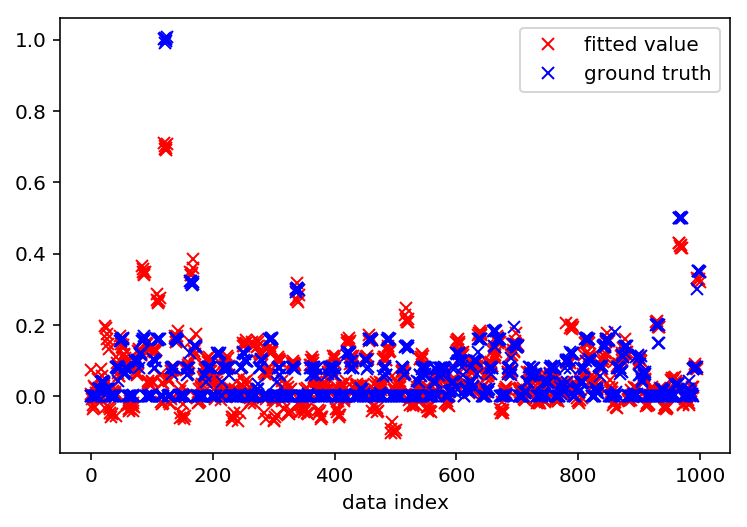

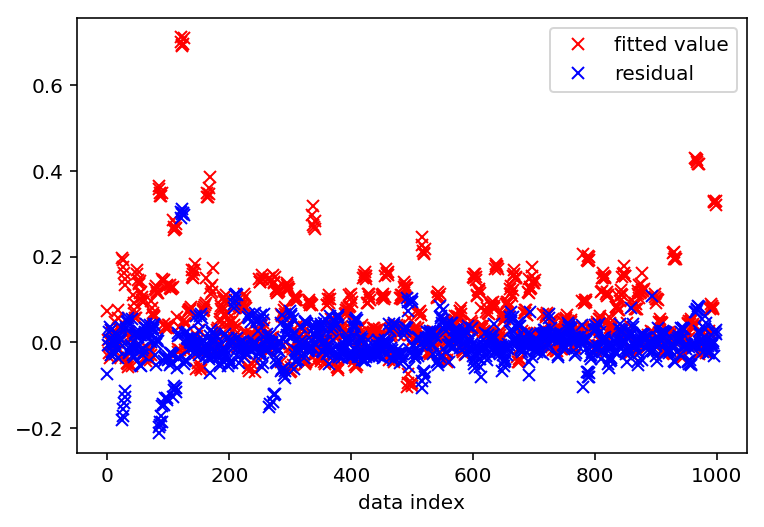

In [17]:
two_plots(predictions, ground_truth)